<a href="https://colab.research.google.com/github/Prakum14/Testfiles/blob/master/Additional_NB_02_LSTM_Movie_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A Program by IISc and TalentSprint
### Additional Notebook 2: LSTM, Sentiment Analysis

## Learning Objectives

At the end of the experiment, you will be able to:

* explore the text data
* understand and perform text pre-processing
* build an LSTM model
* train the model on the IMDB reviews dataset

## Sentiment Classification

Sentiment classification is the automated process of identifying and classifying emotions in the text as positive sentiment, negative sentiment, or neutral sentiment based on the opinions expressed within. It helps determine the nature and extent of feelings conveyed using Natural Language Processing (NLP) to understand what customers say or feel about your brand, products, and services.

Manually reading, classifying, and sorting text data can take a long time. You can lose the essence of what's important when you get stuck manually analyzing and classifying positive and negative sentiments.

Sentiment classification has seen tremendous growth in recent years. Many businesses use it to better understand their customers' feelings, behavior, preferences, and needs.

Automated classification methods enable you to analyze reviews, comments, survey responses, and other public opinions faster. They analyze data to determine the overall tone toward your brand and products, as well as the broader industry and market trends and insights.

### Recurrent Neural Network (RNN)

Recurrent neural network is a type of neural network that is proven to work well with sequence data. Since text is a sequence of words, a recurrent neural network is an automatic choice to solve text-related problems. Here, we will use an LSTM (Long Short Term Memory network) which is a variant of RNN, to solve a movie reviews-based sentiment classification problem.

An LSTM unit consists of a cell, an input gate, an output gate, and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

LSTM networks are well-suited to classification based on time series data and deal well with the exploding and vanishing gradient problems that can be encountered when training traditional RNNs.

<img style="-webkit-user-select: none;margin: auto;" src="https://miro.medium.com/max/1302/1*yr0820z7YNRcDCWGisLC4g.png" width="500" height="250">


<img style="-webkit-user-select: none;margin: auto;" src="https://miro.medium.com/max/1276/1*mvxPFvnDqj2jJrsjevD41A.png" width="500" height="250">







## Dataset Description

The dataset used in this experiment is the [IMDB movie review](http://ai.stanford.edu/~amaas/data/sentiment/) dataset. This dataset for binary sentiment classification contains around 50k movie reviews with the following attributes:

* **review:** text based review of each movie
* **sentiment:** positive or negative sentiment value


In [1]:
#@title Download the dataset
!wget https://cdn.talentsprint.com/aiml/Experiment_related_data/IMDB_Dataset.csv
print("Dataset downloaded successfully!")
!ls | grep ".csv"

--2025-01-08 09:40:27--  https://cdn.talentsprint.com/aiml/Experiment_related_data/IMDB_Dataset.csv
Resolving cdn.talentsprint.com (cdn.talentsprint.com)... 172.105.34.236
Connecting to cdn.talentsprint.com (cdn.talentsprint.com)|172.105.34.236|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://cdn.ap-south-1.linodeobjects.com/public_html/aiml/Experiment_related_data/IMDB_Dataset.csv [following]
--2025-01-08 09:40:27--  https://cdn.ap-south-1.linodeobjects.com/public_html/aiml/Experiment_related_data/IMDB_Dataset.csv
Resolving cdn.ap-south-1.linodeobjects.com (cdn.ap-south-1.linodeobjects.com)... 172.104.36.102, 172.104.52.240, 103.3.61.236, ...
Connecting to cdn.ap-south-1.linodeobjects.com (cdn.ap-south-1.linodeobjects.com)|172.104.36.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 66196356 (63M) [text/csv]
Saving to: ‘IMDB_Dataset.csv’

IMDB_Dataset.csv    100%[===================>]  63.13M  13.5MB/s    in

### Importing Required Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup          # BeautifulSoup is a useful library for extracting data from HTML and XML documents
from numpy import array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, GlobalMaxPooling1D, Dense, Embedding, LSTM, GRU
import pandas.testing as tm

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


### Load the Dataset

In [3]:
movie_reviews = pd.read_csv("/content/IMDB_Dataset.csv")

### Exploratory Data Analysis

In [4]:
# Check the shape of the data
movie_reviews.shape

(50000, 2)

In [6]:
movie_reviews.head()
movie_reviews.tail()
movie_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [7]:
# Check for null Values
movie_reviews.isnull().sum()

,0
review,0
sentiment,0


In [8]:
# Let us view one of the reviews
movie_reviews["review"][5]

'Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble cause, but it\'s not preachy or boring. It just never gets old, despite my having seen it some 15 or more times in the last 25 years. Paul Lukas\' performance brings tears to my eyes, and Bette Davis, in one of her very few truly sympathetic roles, is a delight. The kids are, as grandma says, more like "dressed-up midgets" than children, but that only makes them more fun to watch. And the mother\'s slow awakening to what\'s happening in the world and under her own roof is believable and startling. If I had a dozen thumbs, they\'d all be "up" for this movie.'

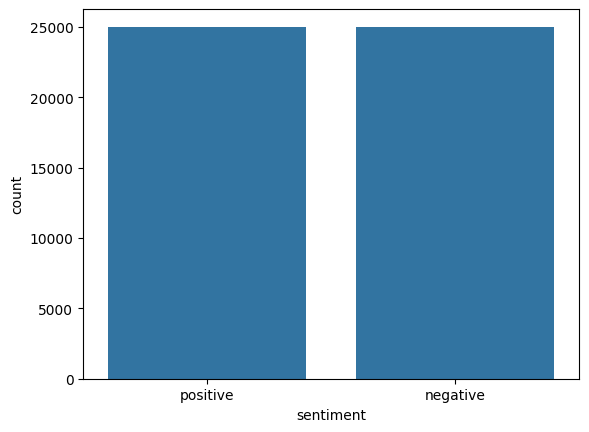

In [9]:
# View the distribution of positive and negative sentiments in the dataset
sns.countplot(x='sentiment', data = movie_reviews)
plt.show()

We can see above that there are an equal number of positive and negative sentiment reviews in the dataset.

###Data Preprocessing

Remove any html tags, punctuations, special characters, stopwords etc. from the review text.

- **Remove HTML, XML, etc.**


In [10]:
# removing the html strips
def strip_html(text):
    # BeautifulSoup is a useful library for extracting data from HTML and XML documents
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [11]:
movie_reviews['review'] = movie_reviews['review'].apply(strip_html)

<ipython-input-10-ecded053059d>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


- **Remove punctuations**

In [12]:
# removing punctuations
def remove_punctuations(text):

    pattern = r'[^a-zA-Z0-9\s]'
    text = re.sub(pattern,'',text)

    # Single character removal
    text = re.sub(r"\s+[a-zA-Z]\s+", ' ', text)

    # Removing multiple spaces
    text = re.sub(r'\s+', ' ', text)

    return text

In [13]:
# Remove puntuations
movie_reviews['review'] = movie_reviews['review'].apply(remove_punctuations)

**Removing stopwords**

Stopwords are English words that do not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. For example, the words like the, he, have etc.

In [14]:
# setting english stopwords
stopword_list = nltk.corpus.stopwords.words('english')
print(stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

The above list of stopwords also contains the word "not", and its other forms such as don't, didn't, etc. We need them for correct sentiment classification.

For example, consider a negative review "*not a good movie*", and if we remove 'not' from it then it becomes a positive review "*a good movie*".

In [15]:
# Exclude 'not' and its other forms from the stopwords list

updated_stopword_list = []

for word in stopword_list:
    if word=='not' or word.endswith("n't"):
        pass
    else:
        updated_stopword_list.append(word)

print(updated_stopword_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', '

In [20]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [17]:
# removing the stopwords
def remove_stopwords(text, is_lower_case=False):
    # splitting strings into tokens (list of words)
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        # filtering out the stop words
        filtered_tokens = [token for token in tokens if token not in updated_stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in updated_stopword_list]
    filtered_text = ' '.join(filtered_tokens)
    return filtered_text

In [21]:
# Apply function on review column
movie_reviews['review'] = movie_reviews['review'].apply(remove_stopwords)

In [22]:
movie_reviews.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,Basically theres family little boy Jake thinks...,negative
4,Petter Matteis Love Time Money visually stunni...,positive


In [23]:
# Convert sentiment labels to integers

movie_reviews['sentiment'] = movie_reviews['sentiment'].apply(lambda x: 1 if x=="positive" else 0)

In [24]:
movie_reviews.head()

,review,sentiment
0,One reviewers mentioned watching 1 Oz episode ...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,Basically theres family little boy Jake thinks...,0
4,Petter Matteis Love Time Money visually stunni...,1


In [25]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(movie_reviews['review'].values, movie_reviews['sentiment'].values,
                                                    test_size=0.20,
                                                    random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)

(40000, 10000, 40000, 10000)

Prepare the Embedding Layer

The embedding layer converts our textual data into numeric data and is used as the first layer for the deep learning models in Keras

In [26]:
# Tokenizer class from the keras.preprocessing.text module creates a word-to-index dictionary
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train_tok = tokenizer.texts_to_sequences(X_train)
X_test_tok = tokenizer.texts_to_sequences(X_test)

The X_train set contains 40,000 lists of integers, each list corresponding to the sentences in a review. Set the maximum length of each list to 100 and add 0 padding to those lists that have a length $\lt$100, until they reach a length of 100.

In [27]:
# Find the vocabulary size and perform padding on both train and test set
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_pad = pad_sequences(X_train_tok, padding='post', maxlen=maxlen, truncating='post')
X_test_pad = pad_sequences(X_test_tok, padding='post', maxlen=maxlen, truncating='post')

In [28]:
print ('number of unique words in the corpus:', vocab_size)

number of unique words in the corpus: 192022


### Build LSTM Model for Text classification

In [29]:
EMBEDDING_DIM = 32

print('Build model...')

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = EMBEDDING_DIM, input_length=maxlen))
model.add(LSTM(units=40,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# Try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model.summary())

Build model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Summary of the built model...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


### Training and Validation

In [30]:
history = model.fit(X_train_pad, y_train, batch_size=128, epochs=3, verbose=1, validation_split=0.2)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 150ms/step - accuracy: 0.5627 - loss: 0.6708 - val_accuracy: 0.6875 - val_loss: 0.6033
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.6564 - loss: 0.6245 - val_accuracy: 0.6229 - val_loss: 0.6300
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 39s 145ms/step - accuracy: 0.6319 - loss: 0.6305 - val_accuracy: 0.7426 - val_loss: 0.5559


### Model Performance

In [31]:
print('Testing...')
y_test = np.array(y_test)
score, acc = model.evaluate(X_test_pad, y_test, batch_size=128)

print('Test score:', score)
print('Test accuracy:', acc)

print("Accuracy: {0:.2%}".format(acc))

Testing...
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 60ms/step - accuracy: 0.7325 - loss: 0.5659
Test score: 0.5617080330848694
Test accuracy: 0.7350000143051147
Accuracy: 73.50%


### Predict a few more samples

In [32]:
#Let us test some  samples
test_sample_1 = "This movie is fantastic! I really like it because it is so good!"
test_sample_2 = "Good movie!"
test_sample_3 = "Maybe I like this movie."
test_sample_4 = "Not to my taste, will skip and watch another movie"
test_sample_5 = "if you like action, then this movie might be good for you."
test_sample_6 = "Bad movie!"
test_sample_7 = "Not a good movie!"
test_sample_8 = "This movie really sucks! Can I get my money back please?"
test_samples = [test_sample_1, test_sample_2, test_sample_3, test_sample_4, test_sample_5, test_sample_6, test_sample_7, test_sample_8]

test_samples_tokens = tokenizer.texts_to_sequences(test_samples)
test_samples_tokens_pad = pad_sequences(test_samples_tokens, maxlen=maxlen)

# predict
pred = model.predict(x=test_samples_tokens_pad)
pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


array([[0.7889449 ],
       [0.8230068 ],
       [0.7929056 ],
       [0.76080585],
       [0.772058  ],
       [0.7909849 ],
       [0.80921674],
       [0.7476196 ]], dtype=float32)

The values close to 1 represents `positive` sentiment, and values close to 0 represents `negative` sentiment.